# Algoritmo de Deutsch-Jozsa


#### Autor: Fernando Ares Robledo
#### email: fernandoaresrobledo@gmail.com


#### Ultima fecha de modificacion: 29 de abril de 2023

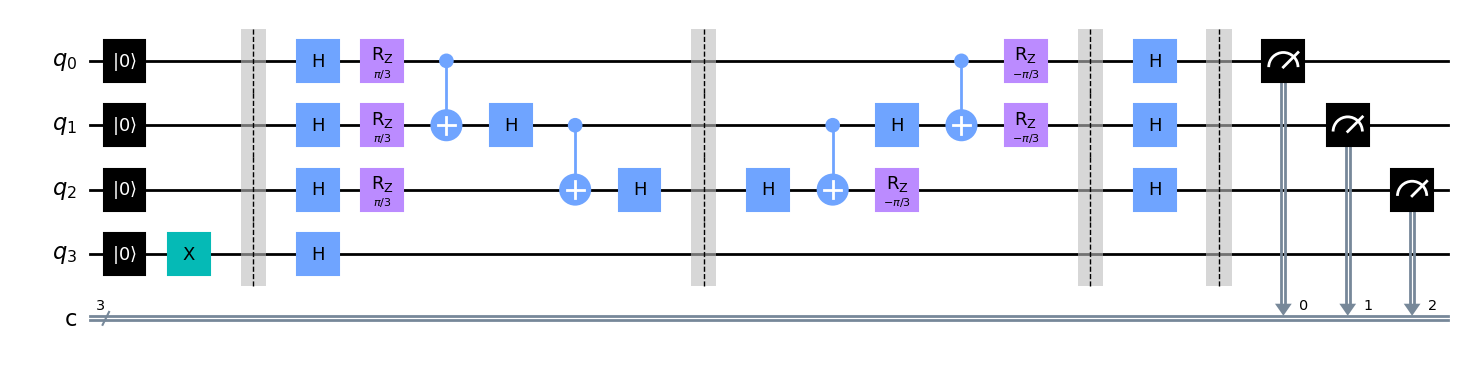

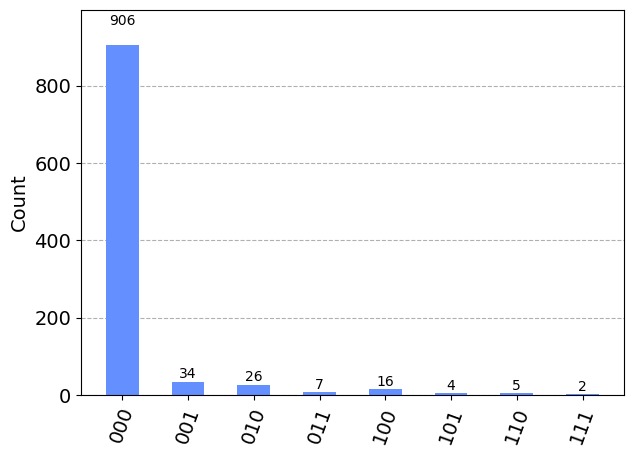

{'000': 912, '001': 25, '010': 17, '100': 25, '011': 12, '110': 7, '111': 1, '101': 1}
La función del oráculo es: Constante


In [1]:
# -*- coding: utf-8 -*-

"""
Nombre del archivo: deutsch_josa.ipynb

Descripción:
Este código implementa el algoritmo de Deutsch-Jozsa en Qiskit, un algoritmo cuántico
que puede determinar si una función es balanceada o constante con una sola consulta al oráculo.
El programa define una clase DeutschJozsa para la construcción y ejecución del circuito cuántico, 
así como una clase oraculos que hereda de DeutschJozsa y contiene varios oráculos predefinidos
para utilizar en el algoritmo. Además, se proporcionan funciones para visualizar el circuito cuántico 
y un histograma de los resultados de la ejecución del circuito. 

Autor: Fernando Ares Robledo
Fecha de creación: 1/02/2023
"""

import numpy as np
from qiskit import QuantumCircuit, Aer, transpile, assemble, execute
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, circuit_drawer
from qiskit.providers.aer import QasmSimulator
import matplotlib.pyplot as plt
from qiskit.providers.fake_provider import *
from IPython.display import display
%matplotlib inline
device_backend = FakeJakarta()

simulador = AerSimulator.from_backend(device_backend)

class DeutschJozsa:
    def __init__(self, n, oracle):
        """
        Inicializa un objeto DeutschJozsa con un tamaño de n qubits y un oráculo dado.

        Args:
            n (int): El número de qubits del circuito.
            oracle (func): Una función que representa el oráculo a utilizar.
        """
        self.n = n
        self.oracle = oracle
        self.circuit = QuantumCircuit(n + 1, n)

    def iniciar_circuito(self):
        """
        Inicializa el circuito cuántico para el algoritmo de Deutsch-Jozsa, aplicando una compuerta X al último qubit
        y una compuerta Hadamard a todos los qubits.
        """
        self.circuit.reset(range(self.n + 1))
        self.circuit.x(self.n)
        self.circuit.barrier()

        for qubit in range(self.n + 1):
            self.circuit.h(qubit)

    def aplicar_oraculo(self):
        """
        Aplica el oráculo dado al circuito cuántico.
        """
        self.oracle(self.circuit, self.n)

    def medir_circuito(self):
        """
        Realiza la medición del circuito cuántico, aplicando una compuerta Hadamard a todos los qubits, 
        seguida de una medición en la base computacional.
        """
        self.circuit.barrier()

        for qubit in range(self.n):
            self.circuit.h(qubit)

        self.circuit.barrier()
        self.circuit.measure(range(self.n), range(self.n))

    def ejecutar_circuito(self):
        """
        Ejecuta el circuito cuántico y devuelve los conteos de las medidas realizadas.

        Returns:
            conteos (dict): Un diccionario que contiene los conteos de cada resultado obtenido durante la ejecución del circuito.
        """
        self.iniciar_circuito()
        self.aplicar_oraculo()
        self.medir_circuito()

    
        shots = 1000 #num de ejecuciones
        t_circuito = transpile(self.circuit, simulador)
        resultado = simulador.run(t_circuito, shots=shots).result()
        conteos = resultado.get_counts(self.circuit)
        return conteos

    def balanceada_o_constante(self, conteos, umbral=0.8):
        """
        Determina si la función del oráculo es balanceada o constante en base a los conteos de salida.
    
        Args:
            conteos (dict): Un diccionario que contiene los conteos de la ejecución del circuito cuántico.
            umbral (float): Un valor entre 0 y 1 que representa el umbral para considerar que la función
                            es constante. Por defecto, es 0.8.
    
        Returns:
            str: Retorna "Constante" si la función es constante, "Balanceada" si es balanceada.
        """
        total_conteos = sum(conteos.values())
        constante = 0
    
        for clave in conteos:
            if clave == '0' * self.n or clave == '1' * self.n:
                constante += conteos[clave]
    
        proporcion_constante = constante / total_conteos
    
        if proporcion_constante >= umbral:
            return "Constante"
        else:
            return "Balanceada"
       


    def ver_circuito(self, style='mpl'):
        """
        Visualiza el circuito cuántico.
        
        Args:
            style (str): Estilo de visualización. Puede ser 'text', 'mpl' o 'latex'.
                         Por defecto, es 'text'.
        """
        if style not in ['text', 'mpl', 'latex']:
            print("Estilo no válido. utilice 'text', 'mpl' o 'latex'.")
            return

        if style == 'text':
            print(self.circuit)
        else:
            display(circuit_drawer(self.circuit, output=style))    


    def dibujar_histograma(self, conteos=None):
        """
        Genera el histograma de los resultados de la ejecución del circuito cuántico.

        Args:
            conteos (dict): Un diccionario opcional que contiene los conteos. Si no se proporciona,
                           se ejecutará el circuito y se utilizarán los resultados obtenidos.
        """
        if conteos is None:
            conteos = self.ejecutar_circuito()

        display(plot_histogram(conteos))


class oraculos(DeutschJozsa):
    """
    Clase que representa un conjunto de oráculos predefinidos para ser utilizados en el algoritmo de Deutsch-Jozsa.

    Esta clase hereda de la clase DeutschJozsa.

    Métodos:
        - balanceado_0(circuito, n): Oráculo balanceado donde los qubits pares están conectados al qubit de salida.
        - balanceado_1(circuito, n): Oráculo balanceado donde los qubits impares están conectados al qubit de salida.
        - balanceado_2(circuito, n): Oráculo balanceado donde todos los qubits pares están conectados al qubit de salida.
        - balanceado_3(circuito, n): Oráculo balanceado donde los qubits que son múltiplos de 3 están conectados al qubit de salida.
        - balanceado_4(circuito, n): Oráculo balanceado que simula la función f(x) = 1 si x = 0 o x = 1, y f(x) = 0 en otro caso.
        - constante_0(circuito, n): Oráculo constante que siempre devuelve 0.
        - constante_1(circuito, n): Oráculo constante que siempre devuelve 1.
        - constante_2(circuito, n): Oráculo constante que devuelve el mismo valor en todas las posibles entradas.
        - constante_3(circuito, n): Oráculo constante que no hace nada.
        - constante_4(circuito, n): Oráculo constante que simula la función f(x) = 0 para todas las entradas.
        - constante_5(circuito, n): Oráculo constante que simula la función f(x) = 1 para todas las entradas.
        - constante_6(circuito, n): Oráculo constante que simula una rotación de ángulo pi/3 sobre todos los qubits de entrada.
    """


    def balanceado_0(self, circuito, n):
        """
        Oráculo balanceado donde los qubits pares están conectados al qubit de salida.

        Args:
            circuito (QuantumCircuit): El circuito cuántico al que se aplica el oráculo.
            n (int): El número de qubits del circuito cuántico.
        """
        for i in range(0, n, 2):
            circuito.cx(i, n)

    def balanceado_1(self, circuito, n):
        """
        Oráculo balanceado donde los qubits impares están conectados al qubit de salida.

        Args:
            circuito (QuantumCircuit): El circuito cuántico al que se aplica el oráculo.
            n (int): El número de qubits del circuito cuántico.
        """
        for i in range(1, n, 2):
            circuito.cx(i, n)

    def balanceado_2(self, circuito, n):
        """
        Oráculo balanceado donde todos los qubits pares están conectados al qubit de salida.

        Args:
            circuito (QuantumCircuit): El circuito cuántico al que se aplica el oráculo.
            n (int): El número de qubits del circuito cuántico.
        """
        for i in range(n):
            if i % 2 == 0:
                circuito.cx(i, n)

    def balanceado_3(self, circuito, n):
        """
        Crea un oráculo balanceado para la función que devuelve 1 si el número de qubits en estado |1> es divisible entre 3.

        Args:
            circuito (QuantumCircuit): El circuito cuántico al que se agregará el oráculo.
            n (int): El número de qubits.

        """
        for i in range(n):
            if i % 3 == 0:
                circuito.cx(i, n)

    def balanceado_4(self, circuit, n):
        """
        Implementa un oráculo balanceado , donde la función es balanceada de la siguiente forma:
        devuelve 0 para los estados en los que la cantidad de unos es par y 1 para los estados en los que la cantidad de unos es impar.

        Args:
            circuito (QuantumCircuit): El circuito cuántico al que se le aplicará el oráculo.
            n (int): El número de qubits del circuito.
        """
        for i in range(n):
            circuit.rz(np.pi / 3, i)

        for i in range(n - 1):
            circuit.cx(i, i + 1)
            circuit.h(i + 1)

        circuit.cx(n - 1, n)

        for i in range(n - 1, 0, -1):
            circuit.h(i)
            circuit.cx(i - 1, i)

        for i in range(n):
            circuit.rz(-np.pi / 3, i)


    def constante_0(self, circuito, n): 
        """
        Implementa un oráculo constante , donde la función es constante y siempre devuelve 0.

        Args:
            circuito (QuantumCircuit): El circuito cuántico al que se le aplicará el oráculo.
            n (int): El número de qubits del circuito.
        """
        for i in range(n):
            circuito.cx(i, n)

    def constante_1(self, circuito, n):
        """
        Implementa un oráculo constante , donde la función es constante y siempre devuelve 1.

        Args:
            circuito (QuantumCircuit): El circuito cuántico al que se le aplicará el oráculo.
            n (int): El número de qubits del circuito.
        """
        pass

    def constante_2(self, circuito, n):
        """
        Implementa un oráculo constante , donde la función es constante y siempre devuelve 0.

        Args:
            circuito (QuantumCircuit): El circuito cuántico al que se le aplicará el oráculo.
            n (int): El número de qubits del circuito.
        """
        circuito.x(n)

    def constante_3(self, circuito, n):
        """
        Implementa un oráculo constante , donde la función es constante y siempre devuelve el mismo estado de entrada.

        Args:
            circuito (QuantumCircuit): El circuito cuántico al que se le aplicará el oráculo.
            n (int): El número de qubits del circuito.
        """
        for i in range(n):
            circuito.id(i)

    def constante_4(self, circuito, n):
        """
        Implementa un oráculo constante , donde la función es constante y siempre devuelve el mismo estado de entrada.

        Args:
            circuito (QuantumCircuit): El circuito cuántico al que se le aplicará el oráculo.
            n (int): El número de qubits del circuito.
        """
        for i in range(n):
            circuito.x(i)
            circuito.x(i)

    def constante_5(self, circuito, n):
        """
        Crea un oráculo constante para la función que devuelve siempre 1.

        Args:
            circuito (QuantumCircuit): El circuito cuántico al que se le aplicará el oráculo.
            n (int): El número de qubits.
        """
        for i in range(n):
            circuito.id(i)
        circuito.x(n)
        circuito.x(n)
    def constante_6(self, circuit, n):
        """
        Crea un oráculo constante para la función que devuelve siempre 0.

        Args:
            circuito (QuantumCircuit): El circuito cuántico al que se le aplicará el oráculo.
            n (int): El número de qubits.

        """
        for i in range(n):
            circuit.rz(np.pi / 3, i)
    
        for i in range(n - 1):
            circuit.cx(i, i + 1)
            circuit.h(i + 1)
    
        circuit.barrier()
    
        for i in range(n - 1, 0, -1):
            circuit.h(i)
            circuit.cx(i - 1, i)
    
        for i in range(n):
            circuit.rz(-np.pi / 3, i)

if __name__ == "__main__":
    n = 3
    dj = oraculos(n, lambda circuito, n: oraculos.constante_6(dj, circuito, n))
    conteos = dj.ejecutar_circuito()
    dj.ver_circuito(style='mpl')
    dj.dibujar_histograma() 
    print(conteos)
    resutlado = dj.balanceada_o_constante(conteos)
    print("La función del oráculo es:", resutlado)